## QUBO Warm‑Start for the Battery MILP (24‑qubit discharge‑timing skeleton)
_A detailed tutorial on constructing a QUBO suitable for QAOA that produces an initial battery discharge schedule._

### Goal
The full battery optimization problem (joint operation of wind + battery) is mixed‑integer and nonlinear, mainly because:
- You must decide when to charge or discharge.
- SOC evolves deterministically.
- Power and energy constraints couple decisions across time.
- There are cycle and operational limits.

Solving the full MILP from a cold start may be slow or get stuck in poor branches.
A quantum warm-start uses QAOA to suggest a binary discharge timing skeleton, after which the classical solver fills in:
- exact charge/discharge magnitudes ct,dtct​,dt​
- SOC trajectory EtEt​
- feasibility under limits
- best revenue

To keep the quantum circuit small and NISQ‑friendly, we isolate only the 24 binary timing decisions, one per hour.

We want a small QUBO (≤ 24 binary variables) that provides an initial guess for the discharge profile $d_t$, which can then be refined by a classical LP/MILP that enforces SOC dynamics and all engineering constraints.

Because of the no netting rule, the wind-scenario revenue term is constant w.r.t. battery decisions, so the battery schedule is driven by prices $p_t$ (and battery constraints). The QUBO therefore uses only $p_t$.

---

## Step 1 — Skeleton decision variables (24 qubits)

Define one binary variable per hour: $x_t \in \{0,1\}$ for $t=1,\dots,24$.

Interpretation:
- $x_t=1$ means “discharge during hour $t$”
- $x_t=0$ means “do not discharge during hour $t$”

To keep the QUBO minimal, we use a coarse discharge magnitude:
$\tilde d_t := 4x_t$ (MWh).

This yields a binary timing skeleton for discharge, which is the warm-start signal we want.

---

## Step 2 — Revenue term in QUBO form

Battery discharge revenue under the skeleton approximation is:
$\sum_{t=1}^{24} p_t \tilde d_t = \sum_{t=1}^{24} 4p_t x_t$.

A QUBO is typically a minimization, so we minimize negative revenue:
$E_{\mathrm{rev}}(x) := -\sum_{t=1}^{24} 4p_t x_t$.

---

## Step 3 — Continuity via a switching penalty

To discourage fragmented on/off behavior, add a quadratic penalty on switches:
$E_{\mathrm{sw}}(x) := \gamma \sum_{t=2}^{24} (x_t-x_{t-1})^2$, with $\gamma\ge 0$.

For binary variables, $x_t^2=x_t$, hence:
$(x_t-x_{t-1})^2 = x_t + x_{t-1} - 2x_tx_{t-1}$.

Interpretation:
- $\gamma$ acts like a cost per switch (up to scaling)
- larger $\gamma$ encourages fewer discharge blocks

---

## Step 4 — Cycle proxy as a cardinality penalty (no extra qubits)

The MILP cycle proxy is:
$\sum_{t=1}^{24} d_t \le 32$ MWh.

Under $\tilde d_t=4x_t$, this becomes:
$4\sum_{t=1}^{24} x_t \le 32$, i.e. $\sum_{t=1}^{24} x_t \le 8$.

With only 24 qubits, a standard way to enforce this without slack bits is a target-cardinality penalty:
$E_{\mathrm{card}}(x) := A\left(\sum_{t=1}^{24} x_t - K\right)^2$, with $A>0$ and $K=8$.

Notes:
- This enforces $\sum_t x_t \approx K$ (typically $\sum_t x_t = K$ if $A$ is large).
- This is a modification of the original inequality, acceptable for warm-starting because the classical refinement step will enforce SOC physics and may reshape discharges.

---

## Step 5 — Final QUBO objective

The final QUBO is:
$\min_{x\in\{0,1\}^{24}} E(x)$

with:
$E(x)=E_{\mathrm{rev}}(x)+E_{\mathrm{sw}}(x)+E_{\mathrm{card}}(x)$

i.e.:
$E(x)=-\sum_{t=1}^{24}4p_t x_t + \gamma\sum_{t=2}^{24}(x_t-x_{t-1})^2 + A\left(\sum_{t=1}^{24}x_t-K\right)^2$.

This uses exactly 24 binary variables.

---

## Step 6 — QUBO matrix form $x^\top Q x$

Write $x=(x_1,\dots,x_{24})^\top$. A QUBO can be written as:
$E(x)=x^\top Q x$,

using the convention:
$x^\top Q x = \sum_t Q_{tt}x_t + \sum_{i<j} Q_{ij}x_ix_j$.

### Diagonal terms (linear coefficients)

Define:
$\deg(t)=1$ for $t\in\{1,24\}$, and $\deg(t)=2$ for $t\in\{2,\dots,23\}$.

Then:
$Q_{tt} = -4p_t + \gamma\,\deg(t) + A(1-2K)$.

### Off-diagonal terms (quadratic couplers)

Cardinality penalty contributes for all $i<j$:
$Q_{ij} \mathrel{+}= 2A$.

Switching penalty contributes for adjacent hours:
$Q_{t-1,t} \mathrel{+}= -2\gamma$ for $t=2,\dots,24$.

Equivalently:
- if $|i-j|=1$, then $Q_{ij}=2A-2\gamma$
- if $|i-j|>1$, then $Q_{ij}=2A$

(Additive constants such as $AK^2$ can be dropped since they do not affect the minimizer.)

---

## Step 7 — Warm start for the MILP

After solving the QUBO, decode the binary solution $x_t^\star$ and define:
$d_t^{(0)} := 4x_t^\star$.

Then run a classical projection/refinement that enforces the real battery physics:
- SOC dynamics: $E_t = E_{t-1} + \eta_{\mathrm{ch}}c_t - d_t$, with $E_0=E_{24}=0$ and $0\le E_t\le 16$
- power limits: $0\le c_t\le 5$ and $0\le d_t\le 4$
- optionally: no-reversal and/or block penalties

A typical refinement approach is:
1. Fix or encourage discharge in the hours where $x_t^\star=1$ (e.g., bounds or a deviation penalty $\sum_t |d_t-d_t^{(0)}|$).
2. Solve the resulting LP/MILP to obtain a feasible $(c_t,d_t,E_t)$.
3. Use that solution as the warm start / incumbent for the full MILP.

Pipeline summary:
$\text{MILP} \Rightarrow \text{QUBO skeleton (24 qubits)} \Rightarrow \text{LP/MILP projection} \Rightarrow \text{full MILP}$.

Let us start with importing all the librabries we are using:

In [ ]:
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli
import numpy as np
from qiskit.circuit.library import XXPlusYYGate
import qiskit
import numpy as np

# QAOA

In this notebook we present the QAOA step to get the initial guess in our optimization solver. In a first time we will be using a simple circuit simulator. Then, we will run this same circuit on a IQM QPU using IQM resonance

### Simple circuit simulator

In [ ]:
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
import matplotlib.pyplot as plt
import pandas as pd

In [74]:
# Example QUBO
Q = (pd.read_csv("../data/qubo_matrix_symmetric.csv",index_col = 0).to_numpy())

In [75]:


# Create QuadraticProgram
qp = QuadraticProgram()
n = Q.shape[0]
for i in range(n):
    qp.binary_var(name=f'x{i}')

# Add quadratic objective
objective = {}
for i in range(n):
    for j in range(n):
        if Q[i, j] != 0:
            objective[(f'x{i}', f'x{j}')] = Q[i, j]

qp.minimize(quadratic=objective)
# Convert to Ising operator
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)
operator, offset = qubo.to_ising()


In [76]:
circuit = QAOAAnsatz(cost_operator=operator, reps=1)
circuit.measure_all()

In [ ]:
circuit.draw(fold = -1)

┌───────────────────┐ ░ ┌─┐                                                                     
    q_0: ┤0                  ├─░─┤M├─────────────────────────────────────────────────────────────────────
         │                   │ ░ └╥┘┌─┐                                                                  
    q_1: ┤1                  ├─░──╫─┤M├──────────────────────────────────────────────────────────────────
         │                   │ ░  ║ └╥┘┌─┐                                                               
    q_2: ┤2                  ├─░──╫──╫─┤M├───────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║ └╥┘┌─┐                                                            
    q_3: ┤3                  ├─░──╫──╫──╫─┤M├────────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║ └╥┘┌─┐                                                         
    q_4: ┤4                  ├─░──╫──╫──╫──╫─┤M├─────────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║ └╥┘┌─┐                                                      
    q_5: ┤5                  ├─░──╫──╫──╫──╫──╫─┤M├──────────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐                                                   
    q_6: ┤6                  ├─░──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                                
    q_7: ┤7                  ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                             
    q_8: ┤8                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                          
    q_9: ┤9                  ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                       
   q_10: ┤10                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                    
   q_11: ┤11                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────────────────
         │   QAOA(γ[0],β[0]) │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                                 
   q_12: ┤12                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                              
   q_13: ┤13                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                           
   q_14: ┤14                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                        
   q_15: ┤15                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                     
   q_16: ┤16                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  
   q_17: ┤17                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────
         │                   │ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               
   q_18: ┤18                 ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─

In [ ]:
def cost_fun_estimator(params, ansatz, hamiltonian, estimator):
    # we map the hamiltonian to the device
    isa_hamiltonian = hamiltonian.apply_layout(layout=ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)

    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    objective_func_vals.append(cost)

    return cost

from qiskit_aer import AerSimulator
backend_aer = AerSimulator()
print(backend_aer)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend_aer)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw(fold=-1)



AerSimulator('aer_simulator')


┌───┐┌─────────────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                ┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [88]:
backend_aer = AerSimulator()

In [ ]:
from scipy.optimize import minimize

init_gamma = 0.05
init_beta = 0.01

init_params = [init_gamma, init_beta]*circuit.reps

objective_func_vals = [] 
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1024

    result = minimize(cost_fun_estimator,
                        x0=init_params,
                        args=(candidate_circuit, operator, estimator),
                        method='COBYLA',
                        options={'maxiter':40, 'disp':True}
                         )
    
print(result)
                      


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -11494.540507812497
       x: [-8.233e-01 -4.775e-01]
    nfev: 24
   maxcv: 0.0
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   24   F =-1.149454E+04    MAXCV = 0.000000E+00
   X =-8.233451E-01  -4.774994E-01



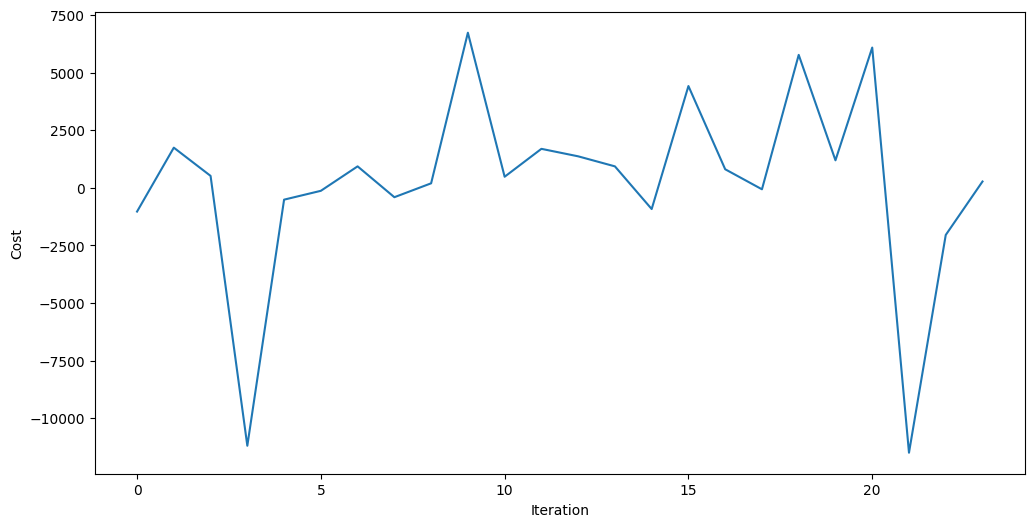

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [70]:
optimized_circuit = isa_circuit.assign_parameters(result.x)

sampler = Sampler(mode=backend)
sampler.options.default_shots = 100_000

pub = (optimized_circuit,)
job = sampler.run([pub])
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{771: 0.00511, 1993: 0.00049, 2445: 0.00073, 3457: 0.00262, 2866: 0.00043, 1539: 0.0008, 3425: 0.00104, 2563: 0.00334, 2857: 0.00106, 2708: 0.00029, 25: 0.00037, 2057: 0.00278, 2828: 0.00092, 2689: 0.00774, 3203: 0.00119, 2657: 0.00126, 3333: 0.00011, 2370: 0.00157, 2921: 0.00081, 35: 0.0002, 2050: 0.0048, 1673: 0.0006, 3018: 0.00032, 3206: 0.00026, 3993: 0.00011, 2945: 0.00601, 769: 0.0059, 3950: 3e-05, 1411: 0.00056, 2083: 0.00065, 456: 0.00019, 2791: 0.00012, 2361: 0.00204, 387: 0.00048, 899: 0.005, 34: 0.00022, 1665: 0.00188, 3093: 8e-05, 2505: 0.00091, 2049: 0.00737, 2986: 0.00023, 2054: 0.00108, 1985: 0.00135, 2359: 0.00034, 770: 0.00429, 268: 0.00054, 647: 0.00103, 2669: 0.00033, 813: 0.00027, 2177: 0.00299, 2360: 0.00137, 13: 0.00077, 2368: 0.00144, 781: 0.00135, 1635: 0.00026, 3329: 0.00512, 2449: 0.0003, 2094: 0.00015, 278: 0.00012, 2944: 0.00321, 825: 0.00104, 2412: 0.0004, 561: 0.00029, 3330: 0.00347, 3337: 0.0018, 3968: 0.00078, 569: 0.00081, 2305: 0.00931, 2304: 0.00616, 

In [71]:
max_key = max(final_distribution_int, key=final_distribution_int.get)
max_value = final_distribution_int[max_key]
print("max_key:", max_key)
print("max_value:", max_value)
# show as binary string (n is already defined)
print("binary:", format(max_key, f'0{n}b'))

max_key: 2305
max_value: 0.00931
binary: 000000000000100100000001


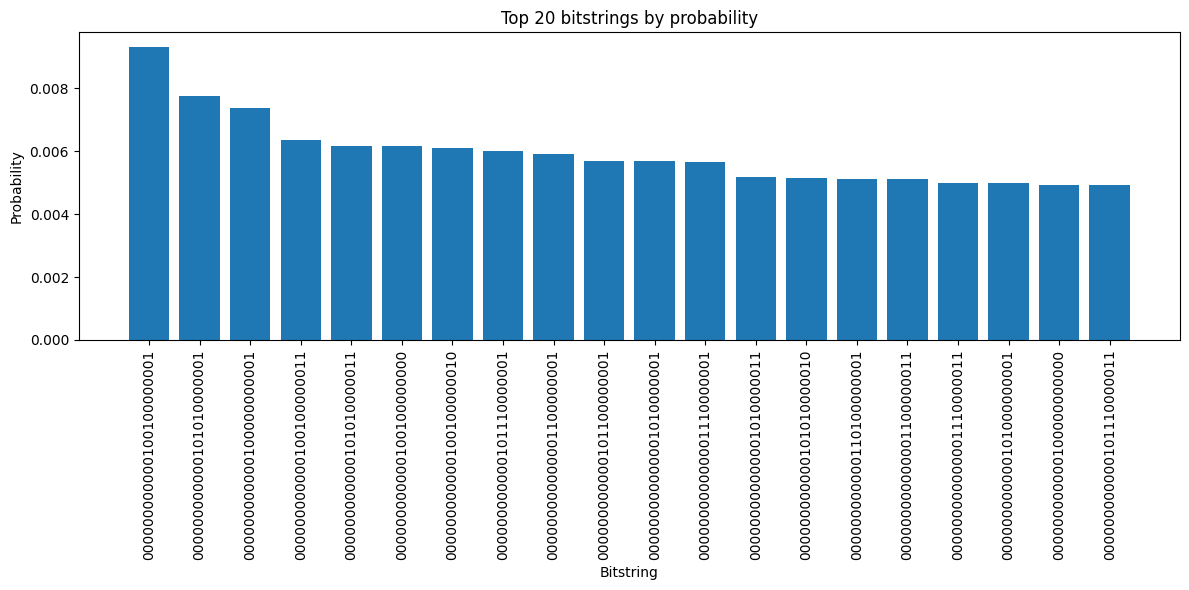

In [73]:
# plot top 20 bitstrings by probability
top_k = 20
items = sorted(final_distribution_int.items(), key=lambda kv: kv[1], reverse=True)[:min(top_k, len(final_distribution_int))]
if not items:
    print("No distribution to plot.")
else:
    ints, probs = zip(*items)
    bins = [format(k, f'0{n}b') for k in ints]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(bins)), probs)
    plt.xticks(range(len(bins)), bins, rotation=90)
    plt.xlabel("Bitstring")
    plt.ylabel("Probability")
    plt.title(f"Top {len(bins)} bitstrings by probability")
    plt.tight_layout()
    plt.show()

### IQM Resonance

In [92]:
API_JAN = "DC0Qws/qFU7X2AVCHWKOji6pwzok6t7oM52V+8Z8MC4Bmxp4qRtxwKeX8zWcVb5F"
from iqm.qiskit_iqm import IQMProvider
provider = IQMProvider("https://resonance.meetiqm.com/", quantum_computer="emerald",
            token=input(API_JAN))
backend_hardware = provider.get_backend()

In [93]:
import qiskit 
qc_transpiled = qiskit.transpile(candidate_circuit,
            
                        layout_method='sabre',
                        backend=backend_hardware,
                        optimization_level=3 )

qc_transpiled.draw(fold = -1)

┌──────────┐     ┌───────────────────┐    ┌───────────┐                      ┌───────────┐ ┌───────────────────────────────┐ ┌───────────┐                                                                                                                                                                                                                                                                                                                      ┌───────────┐┌────────────────────┐┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌───────────┐     ┌────────────────────┐┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  ┌───────────┐┌────────────────────┐  ┌────────────┐                        ┌────────────┐                                                                                                                                                                                                                                                                         ┌───────────────┐                          ┌───────────────┐                                                                                                                     ┌───────────────┐                                                                                                                                                                                                                                                                                                                                              ┌───────────────┐                                               ┌───────────────┐                                                                                                                                                  ┌───────────────┐                                                                                                                                                                                                                                                                                                           ┌───────────────┐                   ┌───────────────┐                             ┌───────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ┌───────────────┐                        ┌───────────────┐                                

In [96]:
from scipy.optimize import minimize

init_gamma = 0.05
init_beta = 0.01

init_params = [init_gamma, init_beta]*circuit.reps

objective_func_vals = [] 
with Session(backend=backend_hardware) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 20_000

    result = minimize(cost_fun_estimator,
                        x0=init_params,
                        args=(qc_transpiled, operator, estimator),
                        method='COBYLA',
                        options={'maxiter':3, 'disp':True}
                         )
    
print(result)
                      


/Users/yanislefur/Documents/IQM_Hackathon/venv/lib/python3.11/site-packages/iqm/qiskit_iqm/iqm_provider.py:191: UserWarning: Unknown backend option(s): {'seed_simulator': None}
  warnings.warn(f"Unknown backend option(s): {unknown_options}")
Progress in queue:   0%|          | 0/1 [00:13<?, ?it/s]


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -14126.898156
       x: [ 5.000e-02  1.010e+00]
    nfev: 3
   maxcv: 0.0
   Return from subroutine COBYLA because the MAXFUN limit has been reached.


   NFVALS =    3   F =-1.412690E+04    MAXCV = 0.000000E+00
   X = 5.000000E-02   1.010000E+00


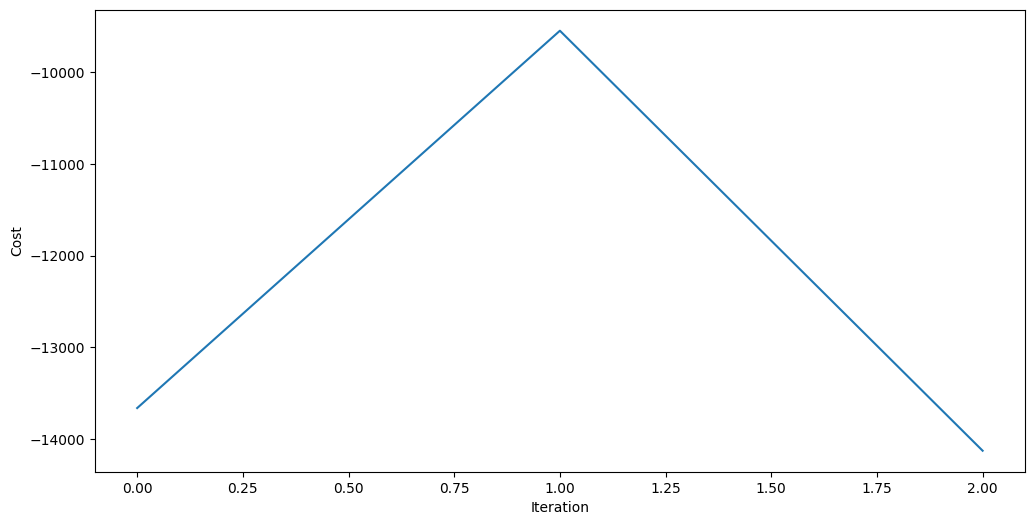

In [97]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [98]:
optimized_circuit = qc_transpiled.assign_parameters(result.x)

sampler = Sampler(mode=backend_aer)
sampler.options.default_shots = 100_000

pub = (optimized_circuit,)
job = sampler.run([pub])
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{6911500: 1e-05, 4972831: 1e-05, 138902: 1e-05, 11020474: 1e-05, 3271815: 1e-05, 2531395: 1e-05, 10911852: 1e-05, 5815134: 1e-05, 7389616: 1e-05, 16581028: 1e-05, 9878009: 1e-05, 10402530: 1e-05, 14257978: 1e-05, 509753: 1e-05, 3979760: 1e-05, 15578688: 1e-05, 5662910: 1e-05, 901937: 1e-05, 16197732: 1e-05, 3210376: 1e-05, 12233641: 1e-05, 4674182: 2e-05, 5602879: 1e-05, 5994073: 1e-05, 11499347: 1e-05, 4316932: 1e-05, 4080126: 1e-05, 3724502: 1e-05, 5086818: 1e-05, 10527174: 1e-05, 10641221: 1e-05, 3539817: 1e-05, 1713683: 1e-05, 13837548: 1e-05, 5300195: 1e-05, 13340495: 1e-05, 3171644: 1e-05, 6415435: 1e-05, 14819848: 1e-05, 16478159: 1e-05, 4162391: 1e-05, 15872420: 1e-05, 12322270: 1e-05, 11707950: 1e-05, 13453827: 1e-05, 10359712: 1e-05, 11205981: 1e-05, 12804376: 1e-05, 9653052: 1e-05, 13840593: 1e-05, 9504084: 1e-05, 15811309: 1e-05, 16759519: 1e-05, 8105164: 1e-05, 2766854: 1e-05, 13089427: 1e-05, 15317073: 1e-05, 11826900: 1e-05, 11260629: 1e-05, 15138462: 1e-05, 4096119: 1e-

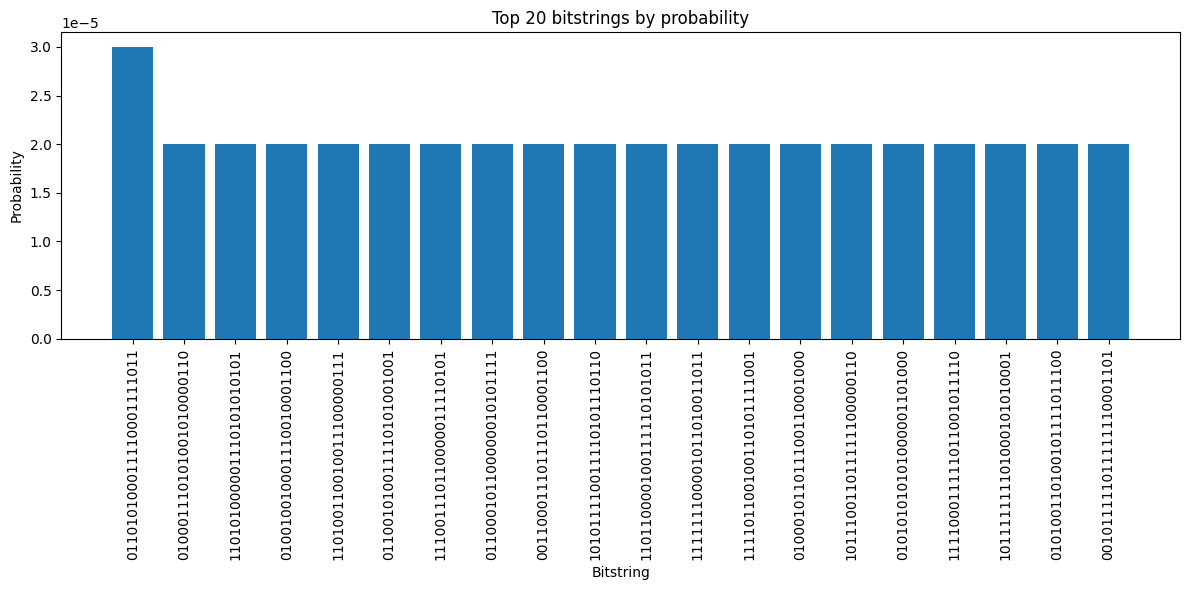

In [99]:
# plot top 20 bitstrings by probability
top_k = 20
items = sorted(final_distribution_int.items(), key=lambda kv: kv[1], reverse=True)[:min(top_k, len(final_distribution_int))]
if not items:
    print("No distribution to plot.")
else:
    ints, probs = zip(*items)
    bins = [format(k, f'0{n}b') for k in ints]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(bins)), probs)
    plt.xticks(range(len(bins)), bins, rotation=90)
    plt.xlabel("Bitstring")
    plt.ylabel("Probability")
    plt.title(f"Top {len(bins)} bitstrings by probability")
    plt.tight_layout()
    plt.show()